# Trabajo Práctico Análisis de Datos

## Librerías

In [1]:
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00


In [2]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import category_encoders as ce
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

## Dataset: Full TMDB Movies Dataset 2024 (Version 685 - 05/09/2025)

### Descripción del dataset

Es el dataset completo generado desde TMDb (The Movie Database). TMDb es una base de datos de películas completa que proporciona información sobre mas de 1M de peliculas desde 1916 hasta la actualidad.

Posee las 24 variable mostradas a continuación

Nro | Variable            | Tipo      | Descripción                                                                      |
----|---------------------|-----------|----------------------------------------------------------------------------------|
01  | id                  | int       | Identificador único de cada película.                                            |
02  | title               | str       | Título de la película.                                                           |
03  | vote_average        | float     | Promedio de votos o calificación otorgada por los espectadores.                  |
04  | vote_count          | int       | Cantidad total de votos recibidos por la película.                               |
05  | status              | str       | El estado de la película (p. ej., Lanzada, Rumoreada, En postproducción, etc).   |
06  | release_date        | str       | Fecha en que la película fue estrenada.                                          |
07  | revenue             | int       | Recaudación total generada por la película.                                      |
08  | runtime             | int       | Duración de la película en minutos.                                              |
09  | adult               | bool      | Indica si la película es apta solo para audiencias adultas.                      |
10  | backdrop_path       | str       | URL de la imagen de fondo de la película.                                        |
11  | budget              | int       | Presupuesto asignado para la película.                                           |
12  | homepage            | str       | URL de la página oficial de la película                                          |
13  | imdb_id             | str       | ID de IMDb de la película.                                                       |
14  | original_language   | str       | Idioma original en el que se produjo la película.                                |
15  | original_title      | str       | Título original de la película.                                                  |
16  | overview            | str       | Descripción breve o sinopsis de la película.                                     |
17  | popularity          | float     | Puntuación de popularidad de la película.                                        |
18  | poster_path         | str       | URL de la imagen del póster de la película.                                      |
19  | tagline             | str       | Eslogan o frase memorable asociada con la película.                              |
20  | genres              | str       | Lista de géneros a los que pertenece la película.                                |
21  | production_companies| str       | Lista de compañías productoras involucradas en la película.                      |
22  | production_countries| str       | Lista de países involucrados en la producción de la película.                    |
23  | spoken_languages    | str       | Lista de idiomas hablados en la película.                                        |
24  | keywords            | str       | Lista de palabras clave asociadas con la película.                               |

### Objetivo: Evaluar distintos modelos de clasificación para predecir la categoría de popularidad de una película

**Popularity** representa una medida relativa de interés del público hacia una película. Es un puntaje calculado por TMDb que refleja cuán popular es una película en la plataforma, basado en su actividad de usuarios.

TMDb no publica la fórmula exacta (es propietaria), pero la comunidad ha documentado que combina los siguientes factores:

|Factor | Descripción |
|-------|-------------|
|Número de votos (vote_count)|	Cuántos usuarios calificaron la película |
|Promedio de votos (vote_average)|	Qué tan alta es la calificación |
|Recencia|	Cuánto tiempo pasó desde el lanzamiento (películas nuevas tienden a tener más tráfico)|
|Tráfico / vistas / búsquedas|	Cuántas veces fue vista o accedida en TMDb recientemente|

Para este trabajo, se establecieron como objetivo tres rangos de popularidad:

| Clase | Rango de Popularidad | Interpretación |
|--------|------------------------|----------------|
| **0 — Baja** | 0 - 1 | Películas con poca o nula atención. |
| **1 — Media** | 1 - 10 | Películas conocidas o con cierto éxito. |
| **2 — Alta** | > 10 | Películas muy populares o éxitos de taquilla. |

### Carga del Dataset

In [3]:
!pip install kagglehub --quiet

# Fuerza a KaggleHub a volver a descargar la versión correcta
dir = kagglehub.dataset_download("asaniczka/tmdb-movies-dataset-2023-930k-movies")
name = os.listdir(dir)[0]
path = os.path.join(dir, name)

print("Dataset descargado en:", path)


100%|██████████| 226M/226M [00:01<00:00, 182MB/s]

Extracting files...


Dataset descargado en: /root/.cache/kagglehub/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/versions/727/TMDB_movie_dataset_v11.csv


In [4]:
# Lectura segura del CSV (sin conflictos de opciones)
df = pd.read_csv(path, on_bad_lines='skip')

# Confirmamos
print("✅ Dataset cargado correctamente")
print(f"📊 Filas: {df.shape[0]} | Columnas: {df.shape[1]}")

✅ Dataset cargado correctamente
📊 Filas: 1305151 | Columnas: 24


In [5]:
df.head(5)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305151 entries, 0 to 1305150
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1305151 non-null  int64  
 1   title                 1305135 non-null  object 
 2   vote_average          1305151 non-null  float64
 3   vote_count            1305151 non-null  int64  
 4   status                1305151 non-null  object 
 5   release_date          1044384 non-null  object 
 6   revenue               1305151 non-null  int64  
 7   runtime               1305151 non-null  int64  
 8   adult                 1305151 non-null  bool   
 9   backdrop_path         333295 non-null   object 
 10  budget                1305151 non-null  int64  
 11  homepage              135655 non-null   object 
 12  imdb_id               642408 non-null   object 
 13  original_language     1305151 non-null  object 
 14  original_title        1305135 non-

### Preprocesamiento

Se eliminan observaciones duplicadas.

In [7]:
# Cantidad de datos duplicados
print("Cantidad de datos duplicados:", df.duplicated().sum())

# Borro todas las duplicadas que tienen el mismo título y release_date
df = df.drop_duplicates(subset=['title', 'release_date'], keep='first')

# Verifico que no hayan quedado duplicados
print("Duplicados restantes:", df.duplicated(subset=['title', 'release_date']).sum())
print(f"Observaciones: {df.shape[0]} | Características: {df.shape[1]}")

Cantidad de datos duplicados: 377
Duplicados restantes: 0
Observaciones: 1282421 | Características: 24


Se convierte 'release_date' a formato DateTime

In [8]:
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["release_date"] = df["release_date"].replace({pd.NaT: np.nan})
df["release_date"].dtypes

dtype('<M8[ns]')

Se reemplazan ceros por nan en variables numericas

In [9]:
# Reemplazo ceros por NaN en columnas específicas
cols = ["revenue", "budget", "runtime"]
df[cols] = df[cols].replace(0, np.nan)

### Análisis del target

Descripción de Popularity

In [10]:
df['popularity'].describe()

,popularity
count,1.282421e+06
mean,1.110969e+00
std,7.152113e+00
min,0.000000e+00
25%,6.000000e-01
50%,6.000000e-01
75%,8.400000e-01
max,2.994357e+03


Histograma de popularity

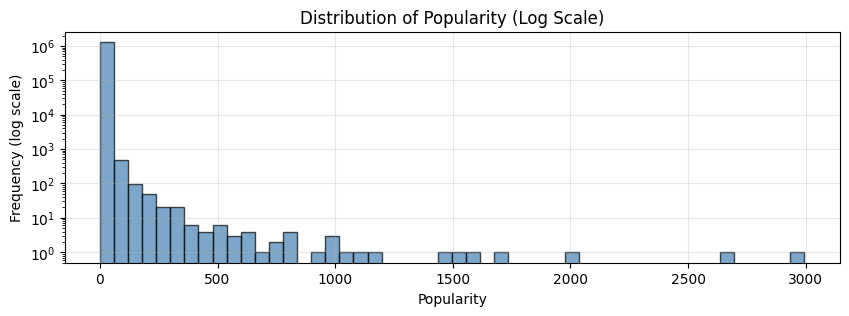

,title,popularity,release_date,vote_average,vote_count
0,Inception,83.952,2010-07-15,8.364,34495
1,Interstellar,140.241,2014-11-05,8.417,32571
2,The Dark Knight,130.643,2008-07-16,8.512,30619
3,Avatar,79.932,2009-12-15,7.573,29815
4,The Avengers,98.082,2012-04-25,7.710,29166
5,Deadpool,72.735,2016-02-09,7.606,28894
6,Avengers: Infinity War,154.340,2018-04-25,8.255,27713
7,Fight Club,69.498,1999-10-15,8.438,27238
8,Guardians of the Galaxy,33.255,2014-07-30,7.906,26638
9,Pulp Fiction,74.862,1994-09-10,8.488,25893


In [11]:
plt.figure(figsize=(10,3))

# Graficar histograma
plt.hist(df["popularity"], bins=50, color="steelblue", edgecolor="black", alpha=0.7)

# Escala logarítmica en el eje Y
plt.yscale("log")

plt.title("Distribution of Popularity (Log Scale)")
plt.xlabel("Popularity")
plt.ylabel("Frequency (log scale)")
plt.grid(True, alpha=0.3)
plt.show()

# Filtrar películas con popularity > 10
top_popular = df[df["popularity"] > 10]
#top_popular = top_popular.sort_values(by="release_date", ascending=True)
top_popular[["title", "popularity", "release_date", "vote_average", "vote_count"]].head(10)

Creación de las clases

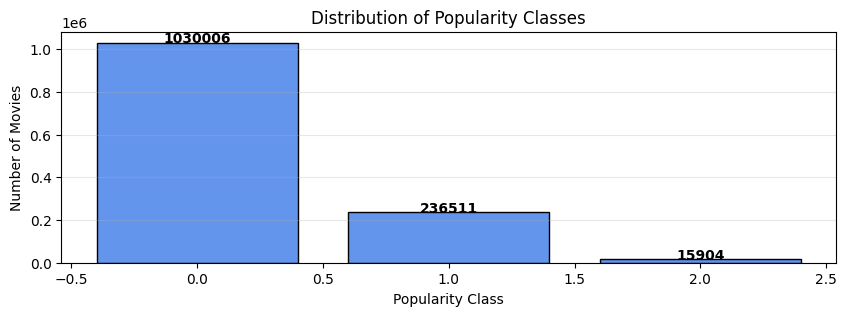

In [12]:
df["popularity_class"] = pd.cut(
    df["popularity"],
    bins=[-1, 1, 10, df["popularity"].max()],
    labels=[0, 1, 2]  # 0 = low, 1 = medium, 2 = high
).astype("int")

plt.figure(figsize=(10,3))

# Contar cuántas películas hay por clase
class_counts = df["popularity_class"].value_counts()

# Graficar barras
plt.bar(class_counts.index, class_counts.values, color="cornflowerblue", edgecolor="black")

# Títulos y etiquetas
plt.title("Distribution of Popularity Classes")
plt.xlabel("Popularity Class")
plt.ylabel("Number of Movies")
plt.grid(True, axis="y", alpha=0.3)

# Mostrar valores sobre las barras
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 50, str(v), ha="center", fontweight="bold")

plt.show()

### Split del dataset

Se eliminan caractéristicas innecesarias (para el objetivo de este trabajo)

In [13]:
df = df.drop(columns=['id', 'title', 'backdrop_path', 'homepage', 'imdb_id', 'original_title', 'overview', 'poster_path', 'tagline'],
             errors='ignore')
print(f"Observaciones: {df.shape[0]} | Características: {df.shape[1]}")

Observaciones: 1282421 | Características: 16


Selección de target y split del dataset

In [14]:
# Definir la variable objetivo a predecir (clasificacion)
y = df['popularity_class']
X = df.drop(columns=['popularity_class', 'popularity'])

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,          # mantiene la proporción de clases
    random_state=42
)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (1025936, 14)
y_train: (1025936,)
X_test: (256485, 14)
y_test: (256485,)


### Análisis de nulos

Cantidad de nulos

In [15]:
# Cantidad de nulos por columna
nulos = X_train.isnull().sum()

# Porcentaje de nulos (sobre el total de filas)
porcentaje = (nulos / len(X_train)) * 100

# Combinar en un solo DataFrame
nulos_df = pd.DataFrame({
    'nulos': nulos,
    'porcentaje': porcentaje
})

# Ordenar de mayor a menor
nulos_df = nulos_df.sort_values(by='nulos', ascending=False)

# Mostrar
print(nulos_df)

                        nulos  porcentaje
revenue               1007819   98.234100
budget                 969904   94.538451
keywords               761114   74.187279
production_companies   574185   55.966941
production_countries   475700   46.367415
spoken_languages       457673   44.610288
genres                 431938   42.101847
runtime                301755   29.412653
release_date           192221   18.736159
vote_average                0    0.000000
status                      0    0.000000
vote_count                  0    0.000000
original_language           0    0.000000
adult                       0    0.000000


Revenue, Budget y Keywords: Se eliminan las las características por alto porcentage de nulos (> 70%)

In [16]:
columns = ['revenue', 'budget', 'keywords']

X_train = X_train.drop(columns=columns, errors='ignore')
X_test = X_test.drop(columns=columns, errors='ignore')

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (1025936, 11)
X_test: (256485, 11)


Release Date: Se imputa con mediana por Status

In [17]:
# Contar nulos en release_date por cada status
nulos_por_status = X_train.groupby("status")["release_date"].apply(lambda x: x.isna().sum())

# Contar totales por cada status
total_por_status = X_train["status"].value_counts()

# Unir ambas series en un mismo DataFrame
nulos_status_df = pd.concat([total_por_status, nulos_por_status], axis=1)
nulos_status_df.columns = ["total", "release_date_nulls"]

# Calcular el porcentaje de nulos
nulos_status_df["null_percentage"] = (nulos_status_df["release_date_nulls"] / nulos_status_df["total"] * 100).round(2)

# Mostrar resultado ordenado por porcentaje de nulos
nulos_status_df.sort_values(by="null_percentage", ascending=False)

,total,release_date_nulls,null_percentage
status,,,
Rumored,391,368,94.12
Canceled,236,222,94.07
Planned,6747,5716,84.72
Post Production,9078,5866,64.62
In Production,13679,4777,34.92
Released,995805,175272,17.60


In [18]:
# Calcular la mediana por grupo

release_date_medians = (
    X_test[X_test["release_date"].notna()]
    .groupby("status")["release_date"]
    .median()
    .sort_values()
)

# Mostrar resultados
print(release_date_medians)

status
Released          2011-04-14 00:00:00
Post Production   2024-09-21 00:00:00
Planned           2025-01-05 12:00:00
In Production     2025-01-15 00:00:00
Rumored           2025-09-29 12:00:00
Canceled          2027-01-22 00:00:00
Name: release_date, dtype: datetime64[ns]


In [19]:
# Imputo medianas por grupo

if X_train["release_date"].isna().any():
    X_train["release_date"] = X_train["release_date"].fillna(
        X_train["status"].map(release_date_medians)
    )

if X_test["release_date"].isna().any():
    X_test["release_date"] = X_test["release_date"].fillna(
        X_test["status"].map(release_date_medians)
    )

Runtime: Se imputa con mediana

In [20]:
runtime_median = X_train['runtime'].median()
print(runtime_median)

X_train["runtime"] = X_train["runtime"].fillna(runtime_median)
X_test["runtime"] = X_test["runtime"].fillna(runtime_median)

66.0


Variables categóricas: Se van a codificar con OneHotEncoder, MultiLabelBinarizer y TargetEncoder.
                       No se requiere tratamiento previo.

### Creación de características

Se crea days_since _realese

In [21]:
# Fecha publicacion dataset

ds_publication_date = pd.to_datetime('2025-09-05')

# Calcular días transcurridos desde el release
X_train["days_since_release"] = (ds_publication_date - X_train["release_date"]).dt.days
X_test["days_since_release"] = (ds_publication_date - X_test["release_date"]).dt.days

X_train = X_train.drop(columns=["release_date"], errors='ignore')
X_test = X_test.drop(columns=["release_date"], errors='ignore')

### Codificacion de categóricas

Informacion del train

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1025936 entries, 957587 to 1003299
Data columns (total 11 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   vote_average          1025936 non-null  float64
 1   vote_count            1025936 non-null  int64  
 2   status                1025936 non-null  object 
 3   runtime               1025936 non-null  float64
 4   adult                 1025936 non-null  bool   
 5   original_language     1025936 non-null  object 
 6   genres                593998 non-null   object 
 7   production_companies  451751 non-null   object 
 8   production_countries  550236 non-null   object 
 9   spoken_languages      568263 non-null   object 
 10  days_since_release    1025936 non-null  int64  
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 87.1+ MB


Adult: Directo a Float

In [23]:
X_train["adult"] = X_train["adult"].astype(float)
X_test["adult"] = X_test["adult"].astype(float)

Status: OneHotEncoder

In [24]:
status_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
status_ohe.fit(X_train[["status"]])

status_train_encoded = status_ohe.transform(X_train[["status"]])
status_test_encoded = status_ohe.transform(X_test[["status"]])

cols_encoded = status_ohe.get_feature_names_out(["status"])

X_train_status_ohe = pd.DataFrame(status_train_encoded, columns=cols_encoded, index=X_train.index)
X_test_status_ohe = pd.DataFrame(status_test_encoded, columns=cols_encoded, index=X_test.index)

X_train = pd.concat([X_train.drop(columns=["status"]), X_train_status_ohe], axis=1)
X_test = pd.concat([X_test.drop(columns=["status"]), X_test_status_ohe], axis=1)

Genres: MultiLabelBinarizer

In [25]:
# Coonvertir strings a listas de etiquetas

for df_part in [X_train, X_test]:
    df_part["genres_list"] = df_part["genres"].apply(
        lambda x: [s.strip() for s in x.split(",")] if isinstance(x, str) else []
    )

# Ajustar solo con train
mlb = MultiLabelBinarizer()
mlb.fit(X_train["genres_list"])

# Transformar ambos
train_genres = pd.DataFrame(
    mlb.transform(X_train["genres_list"]),
    columns=[f"genres_{cls}" for cls in mlb.classes_],
    index=X_train.index
)
test_genres = pd.DataFrame(
    mlb.transform(X_test["genres_list"]),
    columns=[f"genres_{cls}" for cls in mlb.classes_],
    index=X_test.index
)

# Concatenar con los datasets originales
X_train = pd.concat([X_train.drop(columns=['genres', 'genres_list']), train_genres], axis=1)
X_test = pd.concat([X_test.drop(columns=['genres', 'genres_list']), test_genres], axis=1)

print(f"✅ MultiLabelBinarizer aplicado. {len(mlb.classes_)} géneros detectados.")

✅ MultiLabelBinarizer aplicado. 19 géneros detectados.


Original Language, Production Countries, Production Companies, Spoken Languages : TargetEncoder

In [26]:
cols_multilabel = ['original_language', 'production_countries', 'production_companies', 'spoken_languages' ]

def target_encode_multilabel(X_train, X_test, y_train, col, smoothing=0.3):
    """
    Aplica Target Encoding a una columna multietiqueta (lista separada por comas),
    utilizando un vector de target (y_train) externo.

    Parámetros:
        X_train, X_test : pd.DataFrame
            Conjuntos de entrenamiento y prueba.
        y_train : pd.Series o np.ndarray
            Variable objetivo correspondiente a X_train.
        col : str
            Nombre de la columna multietiqueta (por ejemplo 'production_companies').
        smoothing : float, opcional
            Factor de suavizado para el TargetEncoder.

    Retorna:
        X_train_mod, X_test_mod, encoder
    """

    # Convertir string → lista
    for df in [X_train, X_test]:
        df[f"{col}_list"] = df[col].apply(
            lambda x: [s.strip() for s in x.split(",")] if isinstance(x, str) else []
        )

    # Explotar listas (una fila por etiqueta)
    train_exploded = X_train.explode(f"{col}_list").rename(columns={f"{col}_list": "label"})
    test_exploded = X_test.explode(f"{col}_list").rename(columns={f"{col}_list": "label"})

    # Asignar y_train a las filas explotadas (por índice)
    train_exploded[target_col := "target_tmp"] = y_train.loc[train_exploded.index].values

    # Crear y ajustar el encoder con train
    encoder = ce.TargetEncoder(cols=["label"], smoothing=smoothing)
    encoder.fit(train_exploded["label"], train_exploded[target_col])

    # Transformar train y test
    train_exploded["label_te"] = encoder.transform(train_exploded["label"])
    test_exploded["label_te"] = encoder.transform(test_exploded["label"])

    # Reagrupar por índice original (promedio por fila)
    X_train[f"{col}_te"] = train_exploded.groupby(train_exploded.index)["label_te"].mean()
    X_test[f"{col}_te"] = test_exploded.groupby(test_exploded.index)["label_te"].mean()

    # Limpiar columnas originales
    X_train = X_train.drop(columns=[col, f"{col}_list"], errors="ignore")
    X_test = X_test.drop(columns=[col, f"{col}_list"], errors="ignore")

    print(f"✅ TargetEncoder aplicado a '{col}'. Nueva columna: '{col}_te'")

    return X_train, X_test, encoder

for col in cols_multilabel:
    X_train, X_test, _ = target_encode_multilabel(X_train, X_test, y_train, col, smoothing=0.3)

✅ TargetEncoder aplicado a 'original_language'. Nueva columna: 'original_language_te'
✅ TargetEncoder aplicado a 'production_countries'. Nueva columna: 'production_countries_te'
✅ TargetEncoder aplicado a 'production_companies'. Nueva columna: 'production_companies_te'
✅ TargetEncoder aplicado a 'spoken_languages'. Nueva columna: 'spoken_languages_te'


### Análisis de outliers

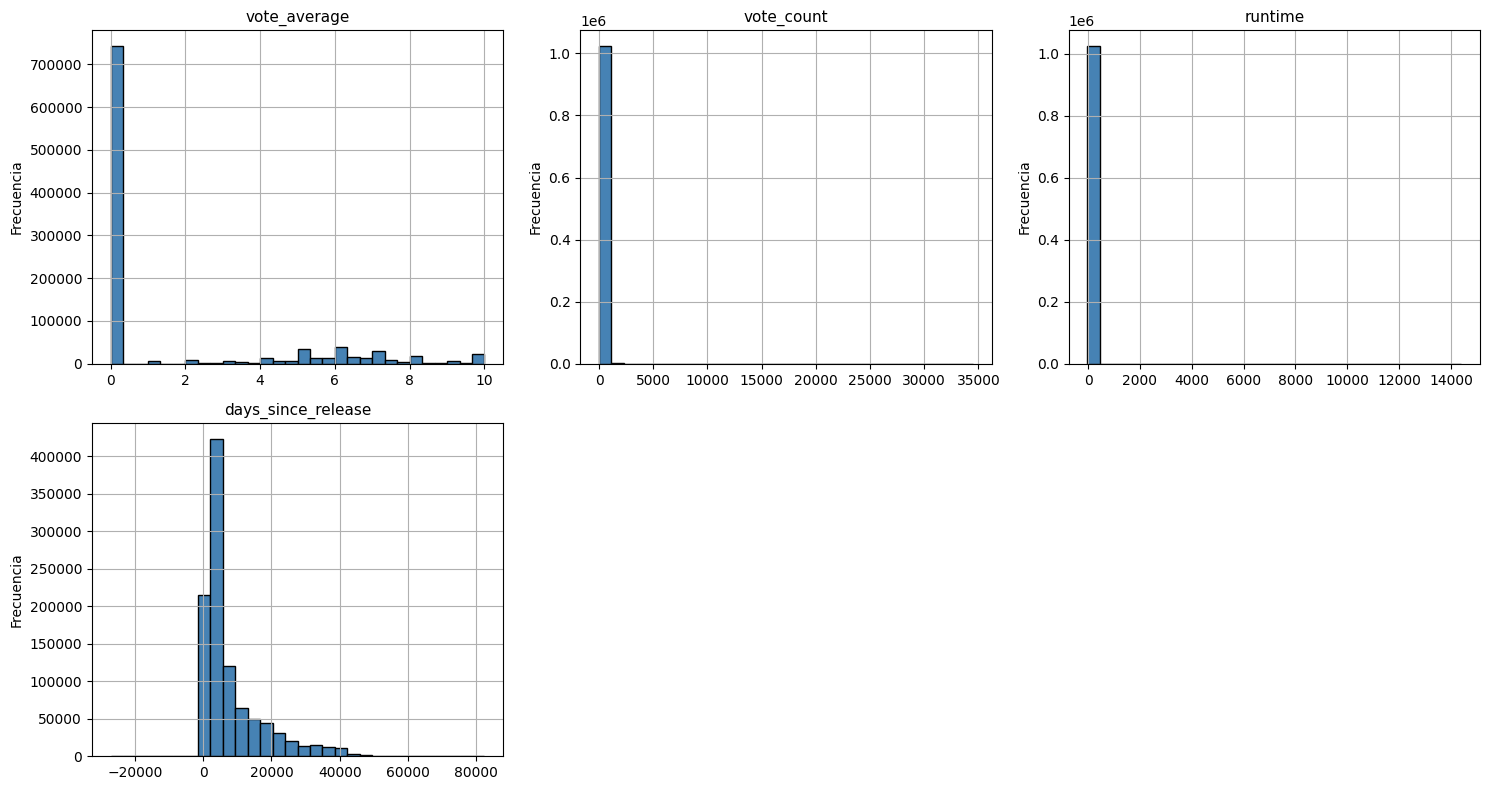

In [27]:
# Lista de columnas numéricas
num_cols = [
    'vote_average', 'vote_count', 'runtime', 'days_since_release'
]

# Configurar los subplots
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # calcula filas necesarias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # para iterar fácilmente

# Crear histogramas
for i, col in enumerate(num_cols):
    ax = axes[i]
    X_train[col].hist(ax=ax, bins=30, color='steelblue', edgecolor='black')
    ax.set_title(col, fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("Frecuencia")

# Si sobran ejes vacíos, los ocultamos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

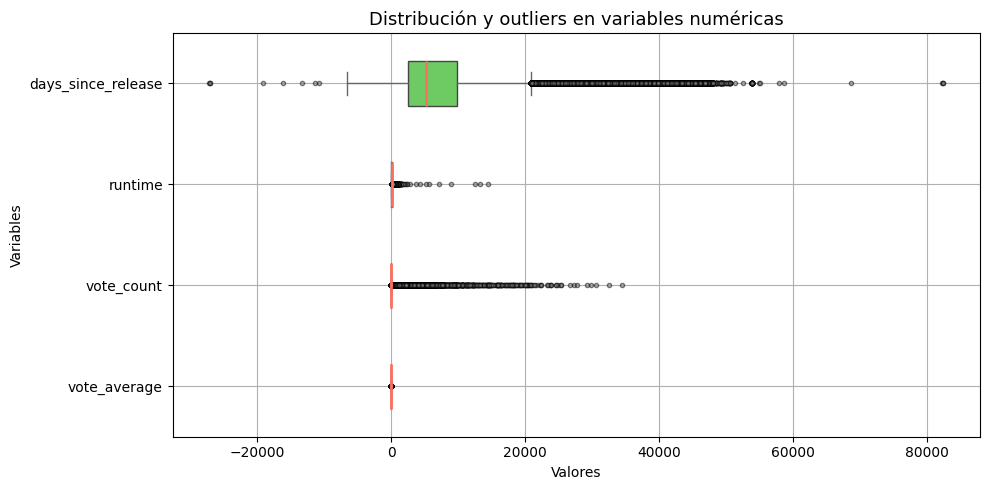

In [28]:
import matplotlib.pyplot as plt

# Variables numéricas reales (sin las codificadas con _te)
num_cols = [
    'vote_average',
    'vote_count',
    'runtime',
    'days_since_release', 'budget'
]

# Verificamos que existan en el dataset
num_cols = [c for c in num_cols if c in X_train.columns]

# Gráfico combinado
plt.figure(figsize=(10, 5))
X_train[num_cols].boxplot(
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="#6ECB63", color="#444"),
    medianprops=dict(color="#FF6F61", linewidth=2),
    whiskerprops=dict(color="#666"),
    capprops=dict(color="#666"),
    flierprops=dict(markerfacecolor="gray", markersize=3, alpha=0.5)
)
plt.title("Distribución y outliers en variables numéricas", fontsize=13)
plt.xlabel("Valores")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()


Runtime: Imputacion con mediana

In [29]:
# No deben existir películas con 0 o 1 minuto ni mayores a 5 horas (300 min)
min_runtime = 30     # películas menores a esto no se consideran "largometrajes"
max_runtime = 300    # 5 horas es un límite razonable

# Detectar cuántas películas están fuera del rango
anomalos = ((X_train['runtime'] < min_runtime) | (X_train['runtime'] > max_runtime)).sum()
print(f"\nPelículas con runtime fuera de rango: {anomalos}")

# Calcular mediana válida del rango lógico
mediana_runtime = X_train.loc[
    (X_train['runtime'] >= min_runtime) & (X_train['runtime'] <= max_runtime),
    'runtime'
].median()

# Reemplazar valores anómalos por la mediana calculada
for X in (X_train, X_test):
    X.loc[(X['runtime'] < min_runtime) | (X['runtime'] > max_runtime), 'runtime'] = mediana_runtime

print(f"Mediana usada para reemplazo: {mediana_runtime}")


Películas con runtime fuera de rango: 262677
Mediana usada para reemplazo: 66.0


Transformación logarítmica para reducir impacto de colas

In [30]:
cols_to_log = ['days_since_release', 'vote_count']

def apply_log_transform(train_df, test_df, cols):
    for df in [train_df, test_df]:
        for col in cols:
            if col in df.columns:
                # Asegurar que no existan valores negativos
                df[col] = np.where(df[col] < 0, 0, df[col])
                df[col] = np.log1p(df[col])
            else:
                print(f"Columna '{col}' no encontrada en el DataFrame.")
    return train_df, test_df

X_train, X_test = apply_log_transform(X_train, X_test, num_cols)

In [31]:
# Verificar rango válido para vote_average (0 a 10)
out_of_range = X_train[(X_train['vote_average'] < 0) | (X_train['vote_average'] > 10)]
print(f"Películas con vote_average fuera del rango [0, 10]: {len(out_of_range)}\n")
display(out_of_range[['vote_average']].head(10))

# Como no existen valores fuera del rango permitido, no se realizará tratamiento adicional.

Películas con vote_average fuera del rango [0, 10]: 0



,vote_average


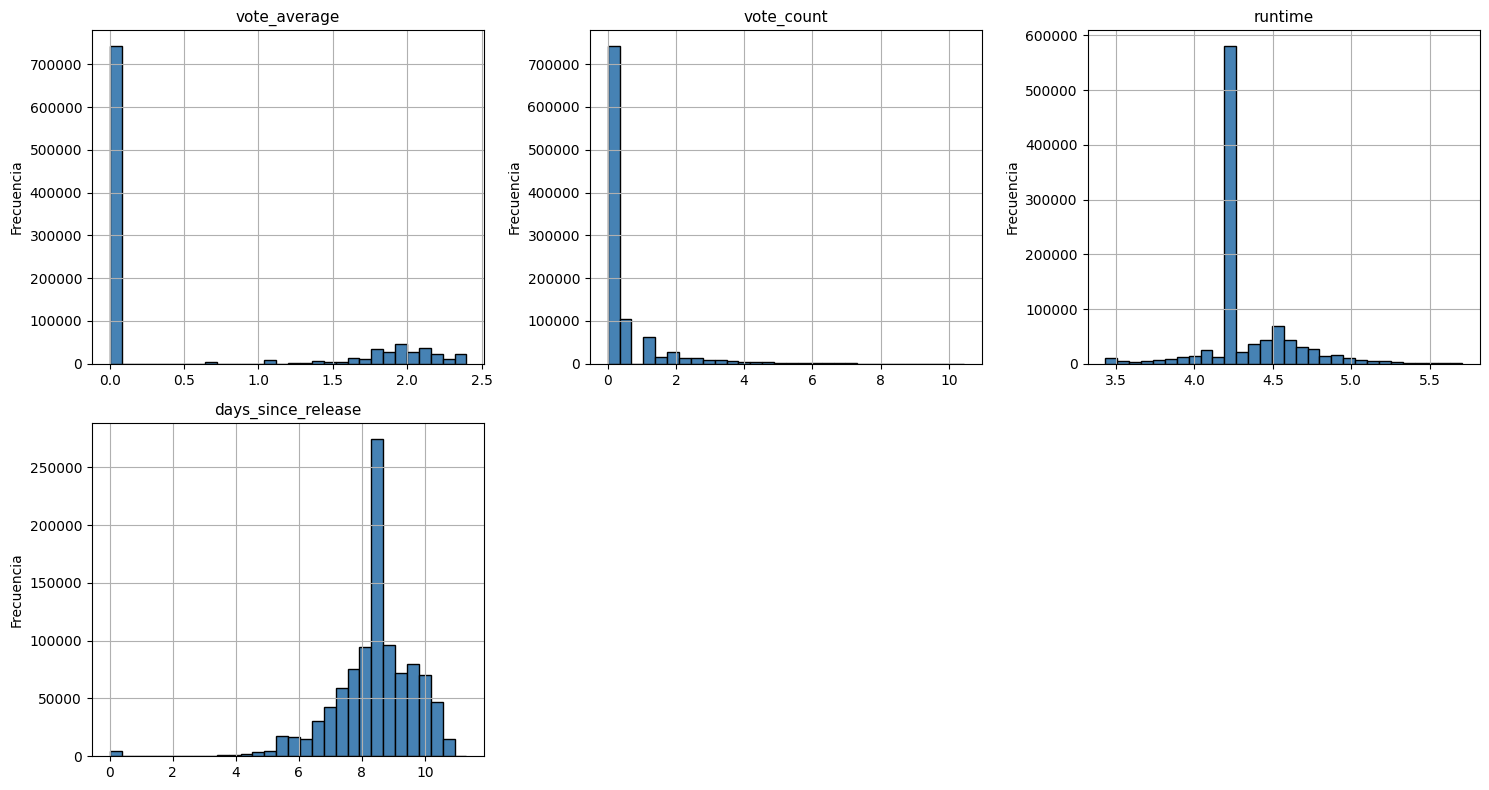

In [32]:
# Lista de columnas numéricas
num_cols = [
    'vote_average', 'vote_count', 'runtime', 'days_since_release'
]

# Configurar los subplots
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # calcula filas necesarias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # para iterar fácilmente

# Crear histogramas
for i, col in enumerate(num_cols):
    ax = axes[i]
    X_train[col].hist(ax=ax, bins=30, color='steelblue', edgecolor='black')
    ax.set_title(col, fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("Frecuencia")

# Si sobran ejes vacíos, los ocultamos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [33]:
total = X_train.shape[0]

cols = ['vote_average', 'vote_count']
resultados = {}

for c in cols:
    ceros = (X_train[c] == 0).sum()
    porcentaje = (ceros / total) * 100
    resultados[c] = {"cantidad": ceros, "porcentaje": porcentaje}

# Mostrar resultados ordenados
for col, info in resultados.items():
    print(f"{col}: {info['cantidad']} películas ({info['porcentaje']:.2f}%) con valor 0")


vote_average: 742118 películas (72.34%) con valor 0
vote_count: 741913 películas (72.32%) con valor 0


### Normalización

In [34]:
# Lista de columnas numéricas a escalar
num_cols = ['vote_average', 'vote_count', 'runtime', 'days_since_release', 'original_language_te', 'production_countries_te', 'production_companies_te', 'spoken_languages_te']

# Crear el scaler
scaler = MinMaxScaler()

# Ajustar sobre el train y transformar ambos conjuntos
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X_train.describe()

,vote_average,vote_count,runtime,adult,days_since_release,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,...,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,original_language_te,production_countries_te,production_companies_te,spoken_languages_te
count,1.025936e+06,1.025936e+06,1.025936e+06,1.025936e+06,1.025936e+06,1.025936e+06,1.025936e+06,1.025936e+06,1.025936e+06,1.025936e+06,...,1.025936e+06,1.025936e+06,1.025936e+06,1.025936e+06,1.025936e+06,1.025936e+06,1.025936e+06,1.025936e+06,1.025936e+06,1.025936e+06
mean,2.212056e-01,4.592174e-02,3.899340e-01,9.971967e-02,7.425476e-01,2.300338e-04,1.333319e-02,6.576434e-03,8.848505e-03,9.706307e-01,...,4.434000e-02,1.814051e-02,1.928385e-02,3.921687e-02,8.540494e-03,7.092060e-03,3.530839e-01,3.019504e-01,1.066174e-01,1.970000e-01
std,3.649332e-01,1.019382e-01,1.283102e-01,2.996260e-01,1.177177e-01,1.516513e-02,1.146971e-01,8.082815e-02,9.364944e-02,1.688394e-01,...,2.058495e-01,1.334595e-01,1.375209e-01,1.941107e-01,9.201936e-02,8.391525e-02,1.016239e-01,2.367530e-01,1.017269e-01,1.621647e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,3.390513e-01,0.000000e+00,6.916478e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.217991e-01,7.482713e-02,5.511468e-02,3.545207e-02
50%,0.000000e+00,0.000000e+00,3.390513e-01,0.000000e+00,7.568850e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.492779e-01,2.426907e-01,5.511468e-02,1.577546e-01
75%,6.541636e-01,6.633877e-02,4.589939e-01,0.000000e+00,8.122144e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.492779e-01,5.375198e-01,1.522729e-01,3.560660e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


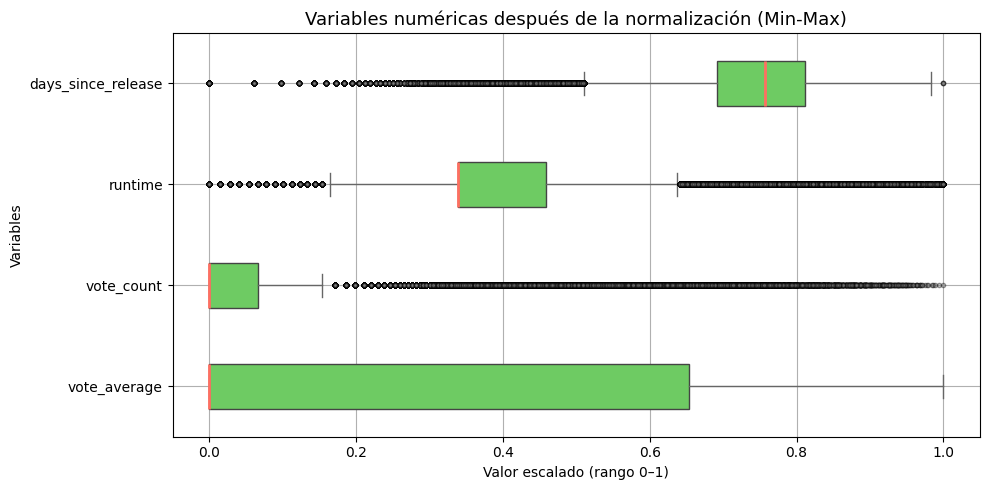

In [35]:
import matplotlib.pyplot as plt

# Solo las variables numéricas originales (sin las codificadas _te)
num_cols = ['vote_average', 'vote_count', 'runtime', 'days_since_release']

# Verificamos que existan
num_cols = [c for c in num_cols if c in X_train.columns]

# Boxplot
plt.figure(figsize=(10, 5))
X_train[num_cols].boxplot(
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="#6ECB63", color="#444"),
    medianprops=dict(color="#FF6F61", linewidth=2),
    whiskerprops=dict(color="#666"),
    capprops=dict(color="#666"),
    flierprops=dict(markerfacecolor="gray", markersize=3, alpha=0.4)
)
plt.title("Variables numéricas después de la normalización (Min-Max)", fontsize=13)
plt.xlabel("Valor escalado (rango 0–1)")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()


### Balance de clases

In [36]:
# Elimina popularity

bal = RandomUnderSampler(random_state=42)

X_train_bal, y_train_bal = bal.fit_resample(X_train, y_train)

X_train_bal.describe()



,vote_average,vote_count,runtime,adult,days_since_release,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,...,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,original_language_te,production_countries_te,production_companies_te,spoken_languages_te
count,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,...,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000,38169.000000
mean,0.493236,0.228351,0.446830,0.053866,0.748587,0.000131,0.012104,0.004585,0.005921,0.976918,...,0.103513,0.052006,0.028531,0.119469,0.019073,0.012497,0.369176,0.425746,0.212375,0.281900
std,0.406579,0.259451,0.131400,0.225755,0.109957,0.011445,0.109352,0.067557,0.076721,0.150165,...,0.304632,0.222041,0.166486,0.324343,0.136784,0.111091,0.113872,0.230020,0.184963,0.152380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046544,0.060081,0.000000,0.004131
25%,0.000000,0.000000,0.339051,0.000000,0.689765,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.349278,0.152571,0.055115,0.125462
50%,0.754115,0.105144,0.453966,0.000000,0.756885,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.349278,0.526622,0.152273,0.333564
75%,0.845749,0.456586,0.532485,0.000000,0.826540,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.349278,0.604706,0.322144,0.395741
max,1.000000,1.000000,1.000000,1.000000,0.962330,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


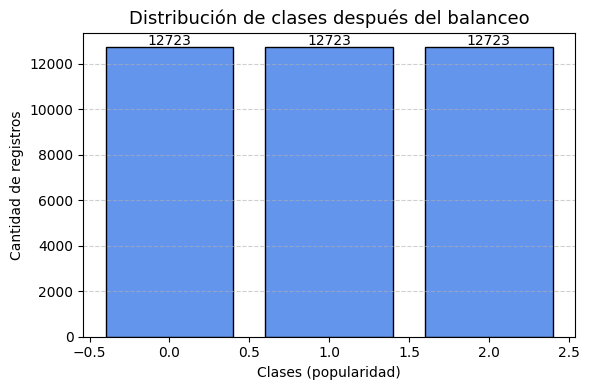

In [37]:
import matplotlib.pyplot as plt

# Conteo de clases balanceadas
counts_after = y_train_bal.value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(counts_after.index, counts_after.values, color="cornflowerblue", edgecolor="black")
plt.title("Distribución de clases después del balanceo", fontsize=13)
plt.xlabel("Clases (popularidad)")
plt.ylabel("Cantidad de registros")
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, val in enumerate(counts_after.values):
    plt.text(i, val + 100, str(val), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


### Reduccion Dimensionalidad

In [38]:
selector = SelectKBest(mutual_info_classif, k=8)

X_train_best = selector.fit_transform(X_train_bal, y_train_bal)
X_test_best = selector.transform(X_test)

selected_indices = selector.get_support()
selected_features = X_train.columns[selected_indices]
scores = selector.scores_[selected_indices]

print("\nCaracterísticas seleccionadas (Inf. mutua ordenadas):")

# Emparejar características con sus scores y ordenar
sorted_features = sorted(zip(selected_features, scores), key=lambda x: x[1], reverse=True)

# Imprimir ordenadas
for feature, score in sorted_features:
    print(f"{feature}: {score:.4f}")


Características seleccionadas (Inf. mutua ordenadas):
vote_count: 0.5373
vote_average: 0.4283
production_companies_te: 0.3239
production_countries_te: 0.2191
spoken_languages_te: 0.2187
runtime: 0.2177
days_since_release: 0.1833
original_language_te: 0.0458


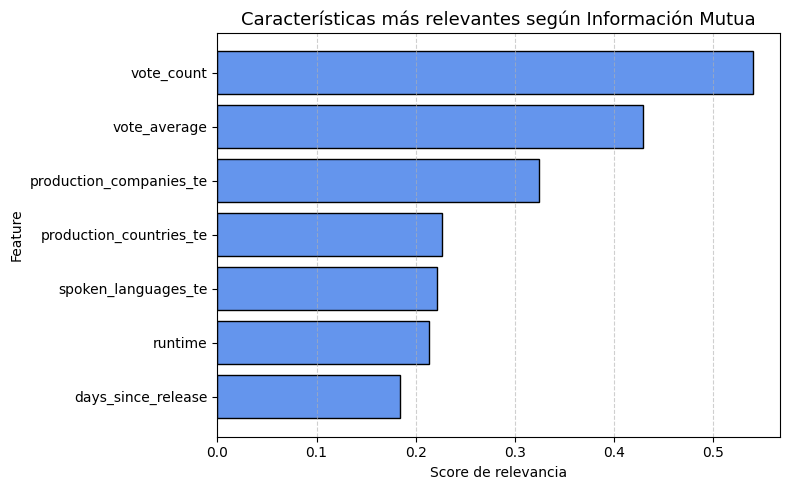

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear DataFrame con los resultados
data = {
    'feature': [
        'vote_count', 'vote_average', 'production_companies_te',
        'production_countries_te', 'spoken_languages_te',
        'runtime', 'days_since_release'
    ],
    'score': [0.5405, 0.4289, 0.3248, 0.2265, 0.2220, 0.2137, 0.1842]
}

df_scores = pd.DataFrame(data).sort_values(by='score', ascending=True)

# Gráfico de barras horizontal
plt.figure(figsize=(8,5))
plt.barh(df_scores['feature'], df_scores['score'], color="cornflowerblue", edgecolor="black")
plt.title("Características más relevantes según Información Mutua", fontsize=13)
plt.xlabel("Score de relevancia")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Pruebas

### XGBoost

Primera prueba — XGBoost modo clasificación

Comenzamos entrenando un modelo XGBoost en modo clasificación multiclase, usando objective='multi:softprob' y el target popularity_class.

Este enfoque permitió obtener probabilidades por clase y evaluar el desempeño inicial del modelo, aunque se observó un desequilibrio importante en las métricas: las clases minoritarias mostraban bajo recall y F1-score, lo que sugiere que el modelo priorizaba la clase mayoritaria.

=== TRAIN ===
Accuracy: 0.804763027587833
              precision    recall  f1-score   support

           0       0.78      0.84      0.81     12723
           1       0.71      0.72      0.72     12723
           2       0.94      0.86      0.90     12723

    accuracy                           0.80     38169
   macro avg       0.81      0.80      0.81     38169
weighted avg       0.81      0.80      0.81     38169



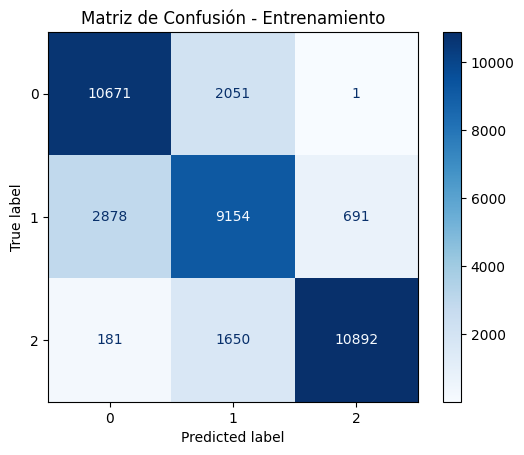


=== TEST ===
Accuracy: 0.8144101994268671
              precision    recall  f1-score   support

           0       0.94      0.84      0.88    206002
           1       0.50      0.72      0.59     47302
           2       0.52      0.86      0.65      3181

    accuracy                           0.81    256485
   macro avg       0.65      0.81      0.71    256485
weighted avg       0.85      0.81      0.83    256485



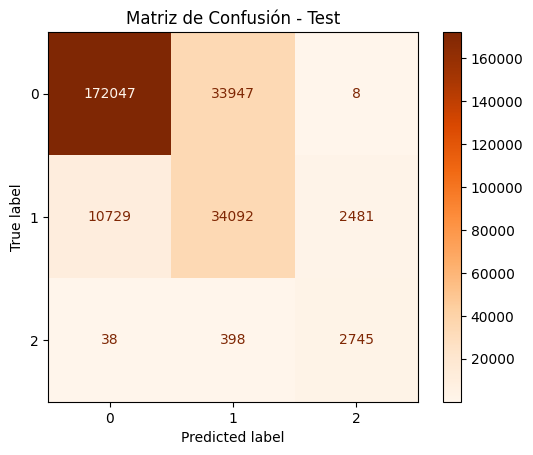

In [42]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# Modelo
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    n_estimators=100,
    learning_rate=0.02,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss'
)

# Entrenar
xgb.fit(X_train_best, y_train_bal, verbose=False)

# Predicciones
y_pred_train = xgb.predict(X_train_best)
y_pred_test = xgb.predict(X_test_best)

# Evaluación
print("=== TRAIN ===")
print("Accuracy:", accuracy_score(y_train_bal, y_pred_train))
print(classification_report(y_train_bal, y_pred_train))

# Matriz de confusión - TRAIN
cm_train = confusion_matrix(y_train_bal, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(cmap="Blues", values_format='d')
plt.title("Matriz de Confusión - Entrenamiento")
plt.show()

print("\n=== TEST ===")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

# Matriz de confusión - TEST
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap="Oranges", values_format='d')
plt.title("Matriz de Confusión - Test")
plt.show()

Segunda prueba — XGBoost modo regresión

Dado que el desempeño del modelo de clasificación fue bajo en las clases 1 y 2, se decidió probar un enfoque de regresión, tratando el target como una variable ordinal (0, 1, 2).

Las predicciones continuas se redondearon al valor de clase más cercano.
Este cambio permitió capturar mejor la relación entre categorías vecinas y mejorar significativamente el balance entre clases y el F1-macro general.

RMSE: 0.2862 | MAE: 0.1646

=== TEST (Reg→Cls, round) ===
Balanced Acc.: 0.7434537092270176
F1-macro     : 0.78789642651329
              precision    recall  f1-score   support

           0     0.9073    0.9698    0.9375    206002
           1     0.7884    0.5618    0.6561     47302
           2     0.8576    0.6988    0.7701      3181

    accuracy                         0.8912    256485
   macro avg     0.8511    0.7435    0.7879    256485
weighted avg     0.8847    0.8912    0.8835    256485



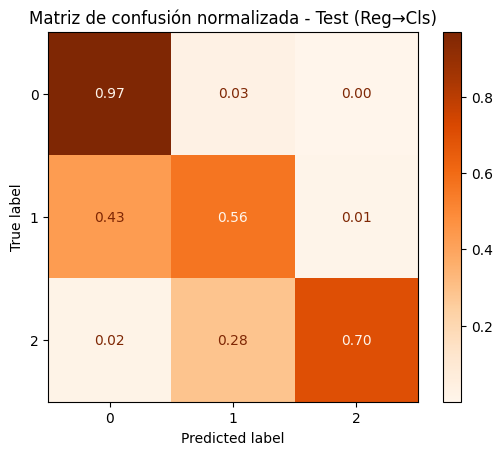

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    balanced_accuracy_score, f1_score, mean_squared_error, mean_absolute_error
)


# tus variables:
# X_train, y_train, X_test, y_test
y_train = y_train.astype(int)
y_test  = y_test.astype(int)

# mini validación (10%) solo para tener eval_set
X_tr, X_es, y_tr, y_es = train_test_split(
    X_train, y_train, test_size=0.10, stratify=y_train, random_state=42
)

# modelo más liviano
reg = XGBRegressor(
    random_state=42,
    n_estimators=600,
    learning_rate=0.10,
    max_depth=5,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method='hist',
    n_jobs=-1,               # usa todos los cores
    eval_metric='rmse'
)

reg.fit(X_tr, y_tr, eval_set=[(X_es, y_es)], verbose=False)

# predicción continua + métricas
y_test_cont = reg.predict(X_test)
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_test_cont))
mae  = mean_absolute_error(y_test, y_test_cont)
print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f}")


# continuo -> clases por redondeo
y_pred_test = np.clip(np.rint(y_test_cont), 0, 2).astype(int)
print("\n=== TEST (Reg→Cls, round) ===")
print("Balanced Acc.:", balanced_accuracy_score(y_test, y_pred_test))
print("F1-macro     :", f1_score(y_test, y_pred_test, average='macro'))
print(classification_report(y_test, y_pred_test, digits=4))
cm = confusion_matrix(y_test, y_pred_test, normalize='true')
ConfusionMatrixDisplay(cm).plot(cmap="Oranges", values_format=".2f")
plt.title("Matriz de confusión normalizada - Test (Reg→Cls)")
plt.show()


In [45]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

bag = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=6),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


RMSE: 0.30499031316847364


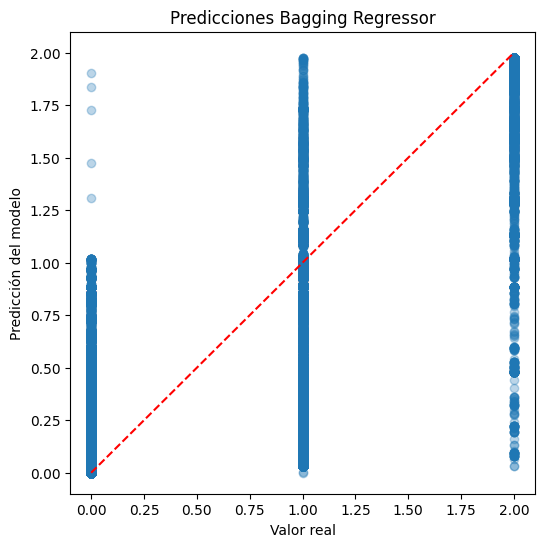

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Valor real")
plt.ylabel("Predicción del modelo")
plt.title("Predicciones Bagging Regressor")
plt.plot([0,2],[0,2],'r--')
plt.show()


El modelo Bagging Regressor se incluyó como un método supervisado de ensamble, con el objetivo de reducir la varianza y comparar su desempeño frente al modelo XGBoost.